In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.1/875.1 kB 5.8 MB/s eta 0:00:0000:0100:01


In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import random
import glob
import shutil
from matplotlib import pyplot as plt

import h5py
from PIL import Image
from io import BytesIO

from ultralytics import YOLO
import yaml

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
import torchvision.transforms as transforms
import cv2
import torchmetrics

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
class CONFIG():
    seed = 42
    img_size =  384
    batch_size =  32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_yolo = False
    
np.random.seed(CONFIG.seed)
torch.manual_seed(CONFIG.seed)
torch.cuda.manual_seed(CONFIG.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(CONFIG.seed)
    
train_images = Path('/kaggle/input/isic-2024-challenge/train-image')
train_csv = Path('/kaggle/input/isic-2024-challenge/train-metadata.csv')
test_csv = Path('/kaggle/input/isic-2024-challenge/test-metadata.csv')
train_hf = Path('/kaggle/input/isic-2024-challenge/train-image.hdf5')
test_hf = Path('/kaggle/input/isic-2024-challenge/test-image.hdf5')
subm = 'submission.csv'

yolo_weights = '/kaggle/input/yolo-seg/pytorch/default/1/yolov8n-seg.pt'

In [5]:
yaml_file_path = '/kaggle/input/isic2024-yolo/yolo8-seg/yolo8-seg.yaml'
shutil.copy(yaml_file_path, '/kaggle/working/yolo8-seg.yaml')
import yaml

yaml_file = '/kaggle/working/yolo8-seg.yaml'

with open(yaml_file, 'r') as f:
    data = yaml.safe_load(f)

data['train'] = '/kaggle/input/isic2024-yolo/yolo8-seg/train'
data['val'] = '/kaggle/input/isic2024-yolo/yolo8-seg/val'
data['test'] = '/kaggle/input/isic2024-yolo/yolo8-seg/test'

with open(yaml_file, 'w') as f:
    yaml.dump(data, f)

In [6]:
if CONFIG.train_yolo:
    model = YOLO(yolo_weights)
    model = model.to(CONFIG.device)
    results = model.train(data='/kaggle/working/yolo8-seg.yaml', epochs=100)
else:
    model = YOLO('/kaggle/input/yolo-trained/pytorch/default/1/best (1).pt')
    model = model.to(CONFIG.device)

In [7]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    
    normalized_image = image.astype(np.float32) / 255.0
    
    target_size = (640, 640)
    resized_image = cv2.resize(normalized_image, target_size, interpolation=cv2.INTER_CUBIC)
    
    final_image = (resized_image * 255).astype(np.uint8)
    
    return final_image


In [8]:
images = []
masks = []
preds = []

image_folder = '/kaggle/input/isic2024-yolo/yolo8-seg/test/images'
for image_file in os.listdir(image_folder):
    
    image_path = os.path.join(image_folder, image_file)
    preprocessed_image = preprocess_image(image_path)
    images.append(preprocessed_image)
    
    mask = cv2.imread('/kaggle/input/ham10000-lesion-segmentations/HAM10000_segmentations_lesion_tschandl/' + image_file[:-4] + '_segmentation.png')
    target_size = (640, 640)
    mask = np.mean(mask, axis=-1, keepdims=False).astype(np.uint8)
    masks.append(cv2.resize(mask, target_size, interpolation=cv2.INTER_CUBIC))
    
    results = model.predict(source=preprocessed_image, verbose=False)
    pred_mask = None
    for result in results:
        if hasattr(result, 'masks') and result.masks is not None:
            pred_masks = result.masks.data.cpu().numpy() 
            if pred_masks.ndim == 3:  
                pred_mask = np.max(pred_masks, axis=0)  
            elif pred_masks.ndim == 2:  
                pred_mask = pred_masks
    if pred_mask is None:
        pred_mask = np.zeros((target_size[1], target_size[0]), dtype=np.uint8)

    preds.append(pred_mask)

In [9]:
images = np.array(images)
masks = np.array(masks)
preds = np.array(preds)
print(preds.shape)
print(images.shape)
print(masks.shape)

(747, 640, 640)
(747, 640, 640, 3)
(747, 640, 640)


In [10]:
dice = torchmetrics.Dice(num_classes=1, multiclass=False).to(CONFIG.device)
iou = torchmetrics.JaccardIndex(num_classes=1, task='binary').to(CONFIG.device)

def calculate_losses(preds, targets): 
    dice_losses = []
    jaccard_losses = []
    
    for pred, target in zip(preds, targets):
        pred = torch.from_numpy(pred)
        pred = pred.to(CONFIG.device)
        target = torch.from_numpy(target)
        target = torch.sigmoid(target).to(CONFIG.device)
        pred = pred.long()
        target = target.long()

        dice_loss = dice(pred, target).item()
        jaccard_loss = iou(pred, target).item()
        
        dice_losses.append(dice_loss)
        jaccard_losses.append(jaccard_loss)
    
    return dice_losses, jaccard_losses

dice_losses, jaccard_losses = calculate_losses(preds, masks)

print(f"Average Dice Score: {np.mean(dice_losses)}")
print(f"Average IOU: {np.mean(jaccard_losses)}")

Average Dice Score: 0.6296907750069297
Average IOU: 0.5613436479784718


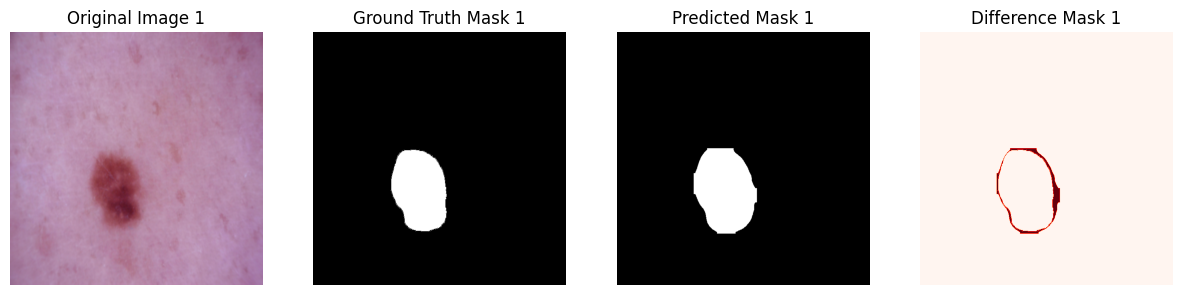

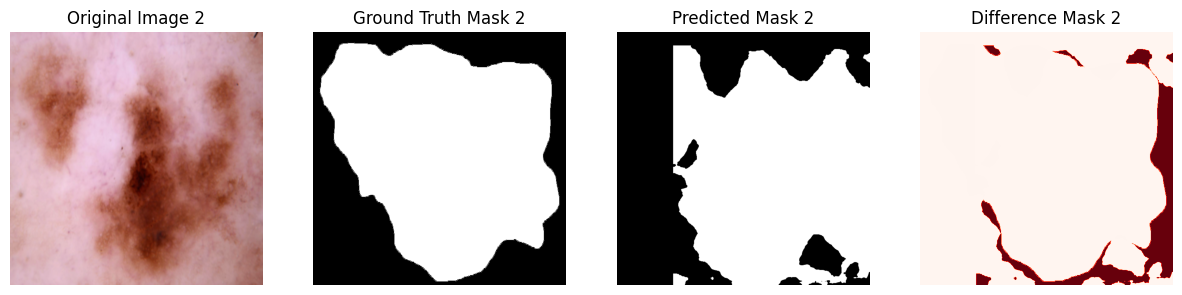

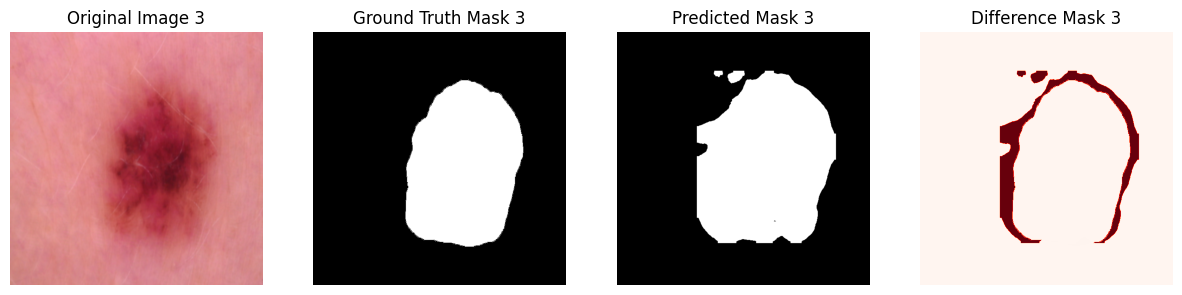

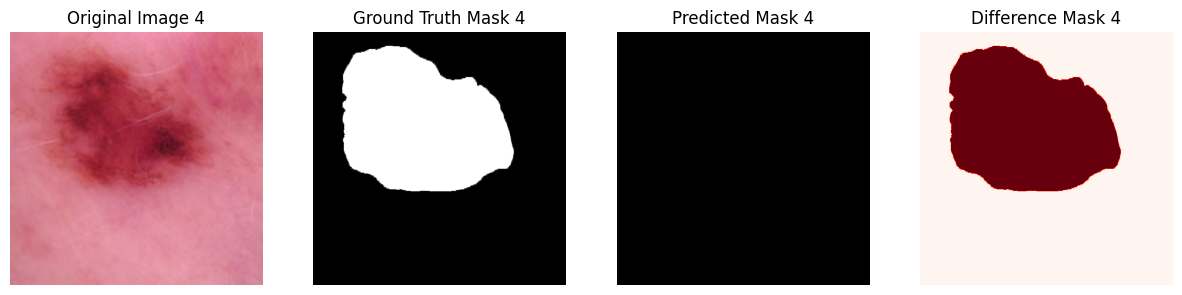

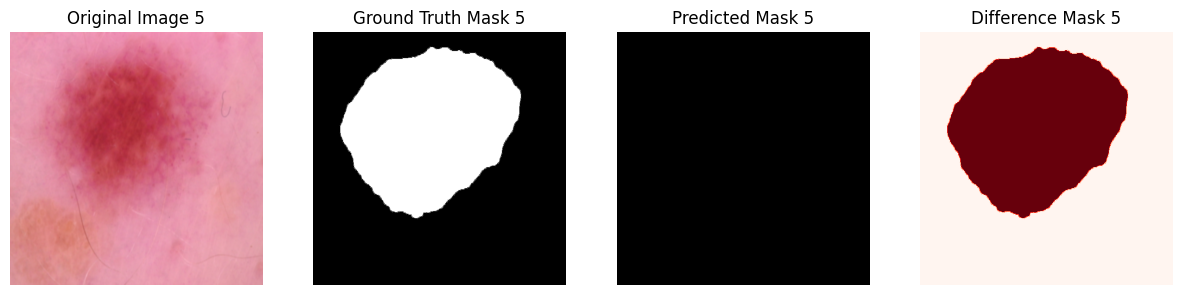

In [16]:
def visualize_results(images, masks, preds, num_samples=5):
    indices = np.random.choice(len(images), num_samples, replace=False)
    cnt = 1
    for i, idx in enumerate(indices):
        image = images[idx]
                
        mask = (masks[idx] > 0.5).astype(np.uint8)
        pred = (preds[idx] > 0.5).astype(np.uint8)
        difference_mask = np.abs(mask - pred)

        
        fig, axs = plt.subplots(1, 4, figsize=(15, 5))
        axs[0].imshow(image)
        axs[0].set_title(f'Original Image {cnt}')
        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title(f'Ground Truth Mask {cnt}')
        axs[2].imshow(pred, cmap='gray')
        axs[2].set_title(f'Predicted Mask {cnt}')
        axs[3].imshow(difference_mask, cmap='Reds')
        axs[3].set_title(f'Difference Mask {cnt}')
        cnt += 1
        for ax in axs:
            ax.axis('off')
        plt.show()

visualize_results(images, masks, preds, num_samples=5)

In [12]:
total_images = 100
count_with_masks = 0
no_mask_benign_counter = 0
counter = 0
image_folder = '/kaggle/input/isic-2024-challenge/train-image/image'
for image_file in os.listdir(image_folder):
    if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(image_folder, image_file)
        
        preprocessed_image = preprocess_image(image_path)
        
        results = model.predict(source=preprocessed_image, verbose=False)
        
        has_mask = False
        for result in results:
            if hasattr(result, 'masks') and result.masks is not None and len(result.masks) > 0:
                has_mask = True
                break
        
        if has_mask:
            count_with_masks += 1
        else:
            img_id = image_file.replace('.jpg', '')
            row = df[df['isic_id'] == img_id]
            if not row.empty and row.iloc[0]['target'] == 0:
                no_mask_benign_counter += 1
        counter += 1
        if counter > total_images:
            break

print(f"Total number of images: {counter}")
print(f"Number of images with masks: {count_with_masks}")
print(f"Number of benign images without masks: {no_mask_benign_counter}")

NameError: name 'df' is not defined

In [ ]:
df = pd.read_csv(train_csv, low_memory=False)
isic_ids = df['isic_id'].values
sampled_ids = random.sample(list(isic_ids), 50)
fp_hdf = h5py.File(train_hf, mode="r")
imgs = []
for id in sampled_ids:
    image = np.array(Image.open(BytesIO(fp_hdf[id][()])))
    image = cv2.GaussianBlur(image, (5, 5), 0)
    
    normalized_image = image.astype(np.float32) / 255.0
    
    target_size = (640, 640)
    resized_image = cv2.resize(normalized_image, target_size, interpolation=cv2.INTER_CUBIC)
    
    final_image = (resized_image * 255).astype(np.uint8)
    
    imgs.append(final_image)

In [ ]:

img_results = []
for img in imgs:
    img_results.append(model(img))

num_images_to_display = 5
for i in range(num_images_to_display):
    img = imgs[i]  
    result = img_results[i]  
    

    if len(result) > 0:
        pred = result[0] 

        if hasattr(pred, 'masks') and pred.masks is not None:
            masks = pred.masks.data.cpu().numpy()  
        else:
            masks = None  
            
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.imshow(img)
        plt.title("YOLO Segmentation")
        plt.axis("off")
        
        if masks is not None:
            for mask in masks:
                plt.imshow(mask, cmap="gray") 
        
        plt.show()
    else:
        print(f"No prediction found for image {i}")
    plt.show()